<a href="https://colab.research.google.com/github/mary270/Deep_Learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Time series Forecasting using LSTM

Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [282]:
# load necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D

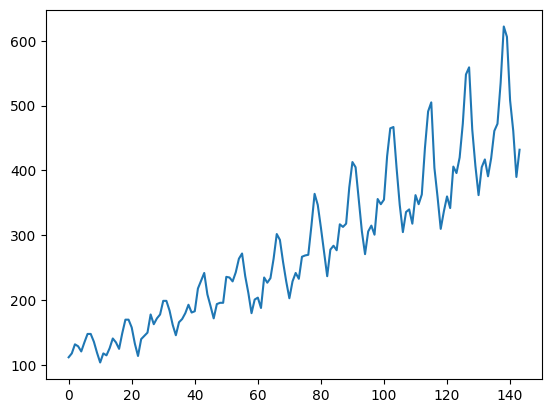

In [283]:
# load the dataset
dataframe = read_csv('/content/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [284]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [285]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [286]:
#We cannot use random way of splitting dataset into train and test as
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [287]:
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [288]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)


In [289]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [290]:
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))


In [291]:
#adding layers and forming the model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#summary of model
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_24 (ConvLSTM2D)  (None, 1, 1, 64)         19200     
                                                                 
 flatten_24 (Flatten)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [292]:
#training the model
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=300)

Epoch 1/300
3/3 - 4s - loss: 0.0456 - val_loss: 0.2051 - 4s/epoch - 1s/step
Epoch 2/300
3/3 - 0s - loss: 0.0302 - val_loss: 0.1434 - 57ms/epoch - 19ms/step
Epoch 3/300
3/3 - 0s - loss: 0.0182 - val_loss: 0.0910 - 44ms/epoch - 15ms/step
Epoch 4/300
3/3 - 0s - loss: 0.0109 - val_loss: 0.0517 - 42ms/epoch - 14ms/step
Epoch 5/300
3/3 - 0s - loss: 0.0075 - val_loss: 0.0300 - 45ms/epoch - 15ms/step
Epoch 6/300
3/3 - 0s - loss: 0.0076 - val_loss: 0.0232 - 43ms/epoch - 14ms/step
Epoch 7/300
3/3 - 0s - loss: 0.0091 - val_loss: 0.0222 - 59ms/epoch - 20ms/step
Epoch 8/300
3/3 - 0s - loss: 0.0091 - val_loss: 0.0220 - 60ms/epoch - 20ms/step
Epoch 9/300
3/3 - 0s - loss: 0.0078 - val_loss: 0.0234 - 47ms/epoch - 16ms/step
Epoch 10/300
3/3 - 0s - loss: 0.0065 - val_loss: 0.0271 - 42ms/epoch - 14ms/step
Epoch 11/300
3/3 - 0s - loss: 0.0060 - val_loss: 0.0317 - 60ms/epoch - 20ms/step
Epoch 12/300
3/3 - 0s - loss: 0.0060 - val_loss: 0.0341 - 45ms/epoch - 15ms/step
Epoch 13/300
3/3 - 0s - loss: 0.0060 - va

In [293]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 7ms/step


In [294]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [295]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 9.91 RMSE


In [296]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 24.65 RMSE


In [297]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

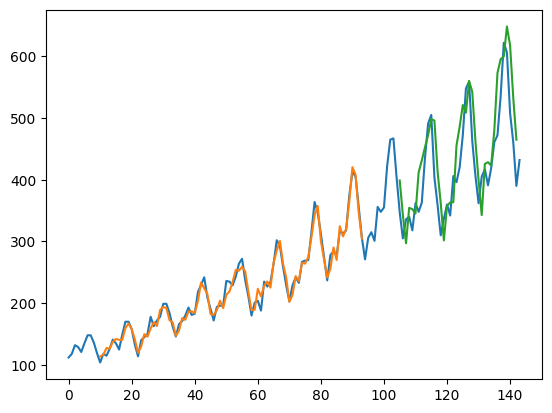

In [298]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()